# The Decision Model
We consider the case where the remaining age of all delivered units is assumed to be fixed and equal to $\mu \in \{1,,\dots,m\}$.
Let $\mathcal{N}:=\{1,\ldots,n\}$ and denote by $q_t$ the estimated required inventory for period $t$ based on the relevant features and an intercept term; $x_{t,i}$ the inventory level of units with a remaining shelf-life of $i\in \{1,\ldots,m-1\}$ days in period $t$; $y_t$ the ordering quantity for period $t$; and $s_{t,i}$ the number of on-hand units with the remaining shelf-life of $i$ days used to satisfy the demand in period $t$, shown by $d_t$. The following linear program jointly determines the coefficients vector $\boldsymbol{\beta}$ and the sequence of variables $\{s_{t,i}\}$ to minimize the empirical cost over a specific number of periods (i.e., $n$), while satisfying the inventory dynamics and Lasso regularization.

\begin{align}
    \min_{\boldsymbol{\beta},\{s_{t,i}\}} \, &\sum_{t=1}^{n}  \big(w_t + c\times l_t\big), \label{objective}\\
    \mbox{s.t.} \nonumber \\
    &q_{t} = \textbf{z}_t \cdot \boldsymbol{\beta} \quad \forall t\in \mathcal{N},  \label{pred}\\
    &y_t = q_{t} - \sum_{i=1}^{m-1}x_{t,i} \quad \forall t\in \mathcal{N},\label{order}\\
    &w_t = x_{t,1} + 1_{\{\mu=1\}} y_t- s_{t,1}\quad \forall t\in \mathcal{N},\label{waste}\\  
    &x_{t+1,j} =  x_{t,j+1} + 1_{\{\mu=j+1\}} y_t - s_{t,j+1} \quad \forall j\in\{1,\ldots, m-2\}, \, t\in \mathcal{N},\\
    &x_{t+1,m-1} =  1_{\{\mu=m\}} y_t - s_{t,m} \quad \forall t\in \mathcal{N},  \label{dynamic}\\
    &\sum_{i=1}^m s_{t,i} + l_t = d_t \quad \forall t\in \mathcal{N},  \label{allocation}\\
    &\sum_{k=1}^{p}u_k \leq \epsilon, \\
    &\beta_k \leq u_k, \quad \forall k \in \{1,\dots,p\}\\
   -&\beta_k \leq u_k, \quad \forall k \in \{1,\dots,p\}\\
    &l_t \geq 0, \label{l_nn}\\
    &w_t \geq 0, \label{w_nn}\\
    &s_{t,i} \geq 0, \quad \forall i\in\{1,\ldots, m\}\label{s_nn}\\
    &x_{t+1,j}\geq 0, \quad \forall j\in\{1,\ldots, m-1\}\label{lc}
\end{align} 

where $1_{\{\mu=a\}}:=1$ if $\mu=a$, and 0 otherwise. 

The variables $w_t$ and $l_t$ respectively denote the number of wasted units and lost demand in period $t$ and are determined through the 3rd and 6th set of constraints. For more detail, the interested readers are encouraged to read the following paper:

Abouee Mehrizi, H., Mirjalili, M. and Sarhangian, V., 2021. Data-Driven Platelet Inventory Management Under Uncertainty in the Remaining Shelf-Life of Units. Available at SSRN 3859034.

# Import Packages

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import date
import scipy.stats as stats
import pickle

# Build the model

In [2]:
# data: It is a DataFrame in Python with the first column including the historical demand values and the other columns the extracted features values (e.g., the average daily demand during the last week)
# ind: It is used for cross validation to distinguish periods for which the model should be trained over.
# start: For some features (e.g., the average daily demand over the past week), we should wait a few periods before starting collecting data (e.g., 7 days).
def estimation(data, epsilon, mu = None, start = 9, ind = None, flag = 0, c = 1):
    
    if ind is None: # Train the model using data in the training set that consists of 731 periods (within the years 2015-2016)
        ind = np.arange(731)
    
    # Feature columns
    XX = data.iloc[0:731, 1:len(data.columns)]
    # Demand column
    d = data.iloc[0:731, 0]

    n = len(d)
    p = len(XX.columns)  

    if mu is None:
        # The maximum possible shelf-life for platelets is 5 days.
        mu = np.zeros((n, 5))
        # The default value for the remaining shelf-life of all received units is set to 3 days.
        mu[:,2] = np.ones(n)
    
    try:  
        model = gp.Model("Estimation")

        # Create decision variables
        b = model.addVars(p+1,  lb=-10000, vtype=GRB.CONTINUOUS, name="b")
        u = model.addVars(p, vtype=GRB.CONTINUOUS, name="u")

        w = model.addVars(n, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="w")
        l = model.addVars(n, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="l")
        x1 = model.addVars(n+1, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="x1")
        x2 = model.addVars(n+1, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="x2")
        x3 = model.addVars(n+1, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="x3")
        x4 = model.addVars(n+1, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="x4")
        y = model.addVars(n, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="y")
        s1 = model.addVars(n, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="s1")
        s2 = model.addVars(n, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="s2")
        s3 = model.addVars(n, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="s3")
        s4 = model.addVars(n, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="s4")
        s5 = model.addVars(n, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="s5")
        
        # Set the initial inventory to zero
        model.addConstr(x1[start] == 0)
        model.addConstr(x2[start] == 0)
        model.addConstr(x3[start] == 0)
        model.addConstr(x4[start] == 0)


        for i in range(start, n, 1):
            if i in ind:
                model.addConstr(y[i] == b[0] + sum(XX.iloc[i,k]*b[k+1] for k in range(p)) - x1[i] - x2[i] - x3[i] - x4[i])
            else:
                model.addConstr(y[i] == d[i])

        # Wastage for day i
        model.addConstrs(w[i] == x1[i] + mu[i][0]*y[i] - s1[i] for i in range(start, n, 1))
        
        # Update the inventory levels for the next day
        model.addConstrs(x1[i+1] == x2[i] + mu[i][1]*y[i] - s2[i] for i in range(start, n, 1))   
        model.addConstrs(x2[i+1] == x3[i] + mu[i][2]*y[i] - s3[i] for i in range(start, n, 1))
        model.addConstrs(x3[i+1] == x4[i] + mu[i][3]*y[i] - s4[i] for i in range(start, n, 1))    
        model.addConstrs(x4[i+1] == mu[i][4]*y[i] - s5[i] for i in range(start, n, 1))
        
        # Allocation constraint to determine the shortage for day i
        model.addConstrs(s1[i] + s2[i] + s3[i] + s4[i] + s5[i] + l[i] == d[i] for i in range(start, n, 1))

        
        model.addConstrs(u[i] + b[i+1] >= 0 for i in range(p))
        model.addConstrs(u[i] - b[i+1] >= 0 for i in range(p))

        # Set optimization objective
        model.setObjective(sum(w[i] + c*l[i] for i in ind) , GRB.MINIMIZE)   

        # Find the coefficients vector for the given values of the sparsity penalty
        coeffients_matrix = np.zeros((p+1, len(epsilon)))
        for i in range(len(epsilon)):
            model.addConstr(u.sum() <= epsilon[i])

            model.Params.OutputFlag = flag

            # Optimize
            model.optimize()

            coeffs = [b[j].x for j in range (p+1)]
            coeffients_matrix[:, i] = coeffs

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ": " + str(e))
    except AttributeError:
        print('Encountered an attribute error')
    
    return coeffients_matrix

# Build the cross validation
We first find the best value of the epsilon hyperparameter for each of the possible remaining age values $\mu$. Then, we redo cross validation under uncertainty in the remaining age of delivered units and pick the best value of $\mu$.

In [3]:
def pos(x): return max(x,0)

In [4]:
def create_folds(n, nfold):
    foldid = np.zeros(n)
    fold_len = np.int_(np.floor( (n + 0.1) / nfold ))
    for i in range(nfold):
        if i < nfold - 1:
            foldid[(i*fold_len):((i+1)*fold_len)] = [(i + 1) for j in range(fold_len)]
        else:
            foldid[(i*fold_len):n] = [(i + 1) for j in range(n-i*fold_len)]
    return foldid

In [5]:
def compute_prediction_statistics (d, pred, mu = None, start = 9):
        
    n = len(d)
    x = np.zeros((n, 4))
    y = np.zeros(n)
    w = np.zeros(n)
    l = np.zeros(n)
    
    if mu is None:
        mu = np.zeros((n, 5))
        mu[:,2] = np.ones(n)
        
    for i in range(start, n, 1):
        y[i] = np.ceil(pos(pred[i] - x[i, 0] - x[i, 1] - x[i, 2] - x[i, 3]))
        w[i] = pos(x[i, 0] + mu[i][0]*y[i] - d[i])
        l[i] = pos(d[i] - x[i, 0] - x[i, 1] - x[i, 2] - x[i, 3] - y[i])
        if i < n - 1:
            x[i+1, 0] = pos(x[i, 1] + mu[i][1]*y[i] - pos(d[i] - x[i, 0] - mu[i][0]*y[i]))
            x[i+1, 1] = pos(x[i, 2] + mu[i][2]*y[i] - pos(d[i] - x[i, 0] - mu[i][0]*y[i] - x[i, 1] - mu[i][1]*y[i]))
            x[i+1, 2] = pos(x[i, 3] + mu[i][3]*y[i] - pos(d[i] - x[i, 0] - mu[i][0]*y[i] - x[i, 1] - mu[i][1]*y[i] - x[i, 2] - mu[i][2]*y[i]))
            x[i+1, 3] = pos(mu[i][4]*y[i] - pos(d[i] - x[i, 0] - mu[i][0]*y[i] - x[i, 1] - mu[i][1]*y[i] - x[i, 2] - mu[i][2]*y[i] - x[i, 3] - mu[i][3]*y[i]))
            
    return w, l

In [6]:
# hmu: hyperparameter \mu
def cross_validation(data, hmu = None, start = 9, cost=1):
    
    XX = data.iloc[0:731, 1:len(data.columns)]
    d = data.iloc[0:731, 0]

    n = XX.shape[0]
    p = XX.shape[1]
        
    nfolds = 10
    epsilons = [100-i for i in range(101)]

    foldid = create_folds(n, nfolds)
    w_cv = np.zeros((n, len(epsilons)))
    l_cv = np.zeros((n, len(epsilons)))

    XX = XX.values
    XX = np.append(np.ones((n, 1)), XX, axis = 1)
    
    for k in tqdm(range(nfolds)):
        coeffs = estimation(tdemdata, epsilon = epsilons, ind = np.where(foldid != k+1)[0], mu = hmu, c=cost)
        pred1 = np.matmul(XX, coeffs)
        
        for eps in range(len(epsilons)):
            wastage, shortage= compute_prediction_statistics(d, pred = pred1[:, eps], mu = hmu)
            w_cv[np.where(foldid == k+1), eps] = wastage[np.where(foldid == k+1)]
            l_cv[np.where(foldid == k+1), eps] = shortage[np.where(foldid == k+1)]
    return w_cv, l_cv

In [7]:
# We read the DataFrame prepared for prediction, with the first column including the demand values and the other columns features values for 731 days (within the years 2015-2017)
tdemdata = pd.read_csv('SampleData.csv')
tdemdata.head(10)

,Usage,Mon,Tue,Wed,Thu,Fri,Sat,Sun,LWU
0,8,0,0,0,1,0,0,0,NaN
1,1,0,0,0,0,1,0,0,NaN
2,3,0,0,0,0,0,1,0,NaN
3,6,0,0,0,0,0,0,1,NaN
4,7,1,0,0,0,0,0,0,NaN
5,14,0,1,0,0,0,0,0,NaN
6,15,0,0,1,0,0,0,0,NaN
7,6,0,0,0,1,0,0,0,7.714286
8,6,0,0,0,0,1,0,0,7.428571
9,3,0,0,0,0,0,1,0,8.142857


In [9]:
# Find the best value of the epsilon parameter for each possible remaining age hyperparameter \mu.
c = 1
epsilons = [100-i for i in range(101)]
age_epsilon = np.zeros(5)
for i in range(5):
    hypermu = np.zeros((731, 5))
    hypermu[:,i] = np.ones(731)
    w_cv, l_cv = cross_validation(tdemdata, hmu = hypermu, cost = c)
    w_cv = pd.DataFrame(data=w_cv)
    l_cv = pd.DataFrame(data=l_cv)
    cv_loss = w_cv[9:].sum(axis = 0) + c*l_cv[9:].sum(axis = 0)
    index = cv_loss.idxmin()
    age_epsilon[i] = epsilons[index]
age_epsilon    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.93s/it]


array([ 7.,  9., 12., 16.,  4.])

Now, for each value of $\mu$  parameter, we determine the cross-validation estimate of the mean and variance of the prediction cost with the multiple sample paths generated for the uncertain remaining age. To select the best $\mu$, we apply the subset selection procedure described in the book below.

Nelson, B., 2013. Foundations and methods of stochastic simulation: a first course. Springer Science & Business Media.

In [10]:
def compute_prediction_statistics_under_variability (d, pred, age_simulated, replication, ind = None, start = 9):
    
    n = len(d)

    if ind is None:
        ind = np.arange(n)
        
    w = np.zeros((n, replication))
    l = np.zeros((n, replication))    
    y = np.zeros((n, replication))

    np.random.seed(123)

    for rep in range(replication):    
        
        x = np.zeros((n, 4))
        rage = np.zeros((n, 5))
        
        for i in range(start, n, 1):
            if i in ind:
                y[i, rep] = np.ceil(pos(pred[i] - x[i, 0] - x[i, 1] - x[i, 2] - x[i, 3]))
                sage = age_simulated[rep][i, 0:int(y[i, rep])]
                rage[i, 0] = len(np.where(sage == 1)[0])
                rage[i, 1] = len(np.where(sage == 2)[0])
                rage[i, 2] = len(np.where(sage == 3)[0])
                rage[i, 3] = len(np.where(sage == 4)[0])
                rage[i, 4] = len(np.where(sage == 5)[0])

                w[i, rep] = pos(x[i, 0] + rage[i, 0] - d[i])
                l[i, rep] = pos(d[i] - x[i, 0] - x[i, 1] - x[i, 2] - x[i, 3] - y[i, rep])
                if i < n - 1:
                    x[i+1, 0] = pos(x[i, 1] + rage[i, 1] - pos(d[i] - x[i, 0] - rage[i, 0]))
                    x[i+1, 1] = pos(x[i, 2] + rage[i, 2] - pos(d[i] - x[i, 0] - rage[i, 0] - x[i, 1] - rage[i, 1]))
                    x[i+1, 2] = pos(x[i, 3] + rage[i, 3] - pos(d[i] - x[i, 0] - rage[i, 0] - x[i, 1] - rage[i, 1] - x[i, 2] - rage[i, 2]))
                    x[i+1, 3] = pos(rage[i, 4] - pos(d[i] - x[i, 0] - rage[i, 0] - x[i, 1] - rage[i, 1] - x[i, 2] - rage[i, 2] - x[i, 3] - rage[i, 3]))

    return w, l

In [11]:
def cross_validation_under_variability(data, simulated_age, rep = 80, start = 9, cost=1):
    
    XX = data.iloc[0:731, 1:len(data.columns)]
    d = data.iloc[0:731, 0]

    n = XX.shape[0]
    p = XX.shape[1]
        
    nfolds = 10

    foldid = create_folds(n, nfolds)
    w_cv = [np.zeros((n, rep)) for i in range(5)]
    l_cv = [np.zeros((n, rep)) for i in range(5)]

    for k in tqdm(range(nfolds)):
        for r in range(5):
            hmu = np.zeros((n, 5))
            hmu[:, r] = np.ones(n)
            coeffs = estimation(tdemdata, epsilon = [age_epsilon[r]], ind = np.where(foldid != k+1)[0], mu = hmu, c=cost)
            pred = [coeffs[0] + sum(coeffs[j+1]*XX.iloc[i,j] for j in range(p)) for i in range(n)]
            
            wastage, shortage = compute_prediction_statistics_under_variability(d, pred, age_simulated = simulated_age, replication = rep, ind = np.where(foldid == k+1)[0])
            
            w_cv[r][np.where(foldid == k+1)] = wastage[np.where(foldid == k+1)]
            l_cv[r][np.where(foldid == k+1)] = shortage[np.where(foldid == k+1)]
    return w_cv, l_cv

In [12]:
# Data comes from 80 replications generating 50 remaining age samples for each of 731 days within the years 2015-2016.
open_file = open("SimulatedAgeData", "rb")
age_simulated = pickle.load(open_file)
open_file.close()
# See for example the samples generated in the 1st replication, which is an array with 731 rows and 50 columns.
age_simulated[0]

array([[4., 5., 5., ..., 5., 3., 5.],
       [3., 2., 4., ..., 3., 4., 3.],
       [1., 2., 2., ..., 2., 3., 3.],
       ...,
       [6., 4., 5., ..., 5., 4., 3.],
       [4., 5., 2., ..., 4., 3., 4.],
       [4., 5., 5., ..., 5., 3., 4.]])

In [13]:
w_cv, l_cv = cross_validation_under_variability(tdemdata, age_simulated, cost = c)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.35s/it]


In [14]:
# Mean of the prediction cost for each value of \mu parameter
Ybar = [np.mean(w_cv[i].sum(axis = 0) + c*l_cv[i].sum(axis = 0)) for i in range(5)] 

In [15]:
# Variance of the prediction cost for each value of \mu parameter
rep = 80
S2 = [(rep/(rep-1))*np.var(w_cv[i].sum(axis = 0) + c*l_cv[i].sum(axis = 0)) for i in range(5)] 

In [16]:
# next do subset selection with k=5 designs
alpha = 0.01
k = 5
tval = stats.t.ppf((1-alpha)**(1/(k-1)), rep-1)
Subset = [1,2,3,4,5]
for i in range(0,5):
    for j in range(0,5):
        if Ybar[i] > (Ybar[j]+tval*np.sqrt(S2[i]/rep + S2[j]/rep)):
            Subset[i] = 0
print(Ybar,S2,Subset)

[922.125, 317.5625, 253.775, 293.7875, 428.8125] [5.579113924050634, 14.755537974683545, 11.214556962025316, 21.460601265822785, 42.7618670886076] [0, 0, 3, 0, 0]


Finally, the model is refit using all training observations and the selected values of the tuning parameters.

In [17]:
hmu = np.zeros((731, 5))
hmu[:,2] = np.ones(731) # The best remaining age value is \mu = 3 days.

In [18]:
# c = 1
coeffs = estimation(tdemdata, epsilon = [age_epsilon[2]], flag=1, mu = hmu, c=c)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5075 rows, 8793 columns and 20982 nonzeros
Model fingerprint: 0x417dbab1
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 2e+01]
Presolve removed 3643 rows and 5284 columns
Presolve time: 0.01s
Presolved: 1432 rows, 3509 columns, 11294 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.857959e+06   0.000000e+00      0s
    1236    3.1874359e+02   0.000000e+00   0.000000e+00      0s

Solved in 1236 iterations and 0.04 seconds
Optimal objective  3.187435897e+02


In [19]:
indx = np.where(coeffs != 0)[0] # keep the indices of non-zero coefficient
coeff_lasso = coeffs[:,0].tolist()

In [20]:
Names = list(tdemdata.columns[1:len(tdemdata.columns)])
Names.insert(0,'Constant')
beta = {'Covariate': Names, 'Beta': coeff_lasso}
beta = pd.DataFrame(data=beta)
beta = np.round(beta,2)
beta

,Covariate,Beta
0,Constant,8.51
1,Mon,0.64
2,Tue,2.23
3,Wed,1.49
4,Thu,0.00
5,Fri,-1.79
6,Sat,-2.95
7,Sun,-2.54
8,LWU,0.36


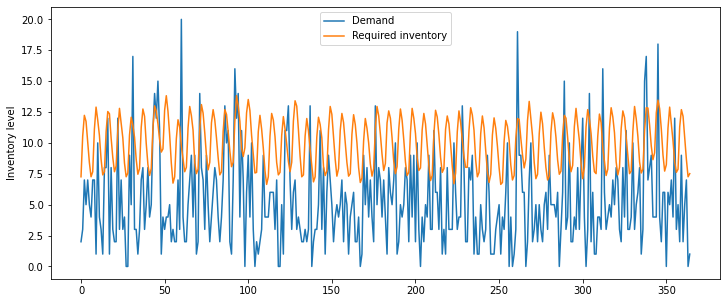

In [21]:
# Plot out-of-sample predictions
XX = tdemdata.iloc[731:1096, 1:len(tdemdata.columns)].reset_index(drop=True)
d = tdemdata.iloc[731:1096, 0].reset_index(drop=True)
n = XX.shape[0]
p = XX.shape[1]
pred = [coeffs[0] + sum(coeffs[j+1]*XX.iloc[i,j] for j in range(p)) for i in range(n)]
plt.figure(figsize=(12, 5))
plt.plot(d, label = "Demand")
plt.plot(pred, label = "Required inventory")
plt.legend()
plt.ylabel('Inventory level')
plt.show()